# Initializations

In [1]:
import os, shutil, importlib
import utils; importlib.reload(utils)

# os.environ["CUDA_VISIBLE_DEVICES"]=''

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import h5py
import keras

from glob import glob

from PIL import Image
from os.path import join as jp

from keras import layers, models, optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.utils import layer_utils

from scipy import ndimage

from sklearn import metrics

from IPython.display import FileLink


%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using TensorFlow backend.


Structure data

In [2]:
path = '../data/dogscats/'
utils.struct_dir(path, ['cat', 'dog'])

Directory structure already exists


Setup paths

In [3]:
path = '../data/dogscats/'
# path = '../data/dogscats/sample/'
path_model = '../data/dogscats/models/vgg16/'
path_test = path + 'test'
path_train = path + 'train'
path_valid = path + 'valid'
path_img_arrays = path + 'img_arrays/'

path_submit = path_model + 'submissions/'
path_checkpoint = path_model + 'checkpoints/'
path_results = path_model + 'results/'

# Load Model

- Load model and finetune weights

In [4]:
import vgg16; importlib.reload(vgg16)
from vgg16 import Vgg16

In [37]:
vgg = Vgg16()

Loading model weights


In [38]:
vgg.ft(2)
vgg.model.load_weights(path_model+'attempt3/checkpoints/weights_conv.h5') 

In [39]:
batch_size = 64

# Model Modifications

## Remove Dropout

- Split the model into conv and dense layers
- Precalculate the output of the convs layers
- Create new model with just the dense layers
- Train new model using output of conv layers as features

### Split Model

In [ ]:
vgg.model.summary()

In [22]:
layers_conv, layers_fc = utils.split_at(vgg.model, layers.Conv2D)

In [23]:
vgg_conv = models.Sequential(layers_conv)

### Load data and pre-calculate conv features

In [85]:
data_train = utils.load_array_bcolz(path_img_arrays+'train.bc')
data_valid = utils.load_array_bcolz(path_img_arrays+'valid.bc')
classes, filenames = utils.get_classes(path)
labels_train = classes[2]
labels_valid = classes[3]

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


In [86]:
# gen = image.ImageDataGenerator()
# batches_train = gen.flow(data_train, labels_train, batch_size=batch_size, shuffle=False)
# batches_valid = gen.flow(data_valid, labels_valid, batch_size=batch_size, shuffle=False)

In [87]:
# feats_conv_train = vgg_conv.predict_generator(batches_train, batches_train.n)
# feats_conv_valid = vgg_conv.predict_generator(batches_valid, batches_valid.n)

In [88]:
# utils.save_array_bcolz(path_img_arrays+'train_conv.b5', feats_conv_train)
# utils.save_array_bcolz(path_img_arrays+'valid_conv.b5', feats_conv_valid)

In [89]:
feats_conv_train = utils.load_array_bcolz(path_img_arrays+'train_conv.b5')
feats_conv_valid = utils.load_array_bcolz(path_img_arrays+'valid_conv.b5')

In [90]:
feats_conv_train.shape

(100, 14, 14, 512)

### Create FC Model

Create fc model by creating a new model of the same architecture as the fc portion of VGG16 with dropout p set to 0. Then copy all the weights from the previous dense layers

In [91]:
vgg_fc = utils.create_model_from_layers(layers_fc)

In [92]:
utils.set_dropout(vgg_fc, 0)

In [93]:
opt = optimizers.Adam(lr=0.000001)
vgg_fc.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train FC Model with conv features

In [95]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
vgg_fc.fit(feats_conv_train, labels_train, batch_size=batch_size, nb_epoch=1,
           validation_data=(feats_conv_valid, labels_valid), callbacks=callbacks)

Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 7s - loss: 0.1424 - acc: 0.9600 - val_loss: 0.0232 - val_acc: 0.9900


Remove non optimal saved weights

In [96]:
epoch_keep = 1
utils.rm_checkpoints(path_checkpoint+'weights_fc', epoch_keep)

### Model Checkpoint - Performs worse

In [20]:
vgg_fc.load_weights(glob(path_checkpoint+'weights_fc.*')[0])

### Create Submission

In [ ]:
batches_test, probs_test = vgg.test(path_test, batch_size=batch_size)
np.save(path_results+'filenames_test_fc.npy', batches_test.filenames)
np.save(path_results+'probs_test_fc.npy', probs_test)

In [ ]:
utils.create_submit(batches_test, probs_test[:, 1], clip=(0.025, 0.975),
                    fname=path_submit+'submit_fc.csv')

In [ ]:
FileLink('../data/dogscats/models/vgg16/submissions/submit_fc.csv')

## Data Aug

- Get image generator, train / valid batches
- Add dense model back onto conv model
- Compile and train (on conv weights from lesson 2 but no dropout)

### Examples

In [11]:
gen = image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.2, height_shift_range=0.2,
                               shear_range=0.15,
                               zoom_range=0.3,
                               channel_shift_range=10.0,
                               horizontal_flip=True,
                               fill_mode='constant'
                              )

Read in one image and test

In [12]:
img = np.expand_dims(ndimage.imread(path_train + '/cat/cat.400.jpg'), 0)
img.shape

(1, 374, 500, 3)

In [13]:
aug_gen = gen.flow(img)

In [14]:
imgs = [aug_gen.next()[0] for i in range(0, 8)]

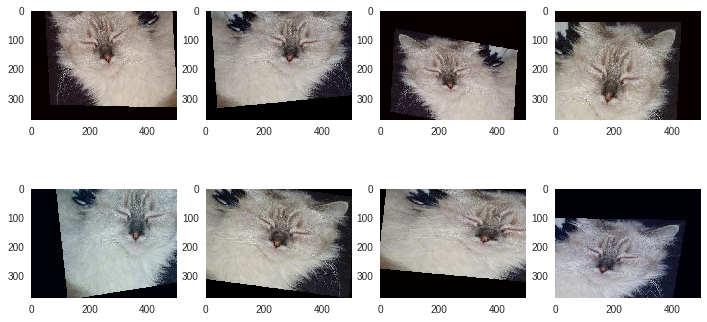

In [15]:
utils.plot_imgs(imgs, rows=2)

### Generate Batches

In [47]:
# gen = image.ImageDataGenerator(rotation_range=10,
#                                width_shift_range=0.2, height_shift_range=0.2,
#                                shear_range=0.15,
#                                zoom_range=0.3,
#                                channel_shift_range=10.0,
#                                horizontal_flip=True,
#                                fill_mode='constant'
#                               )
gen = image.ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               shear_range=0.05,
                               zoom_range=0.1,
                               channel_shift_range=3.0,
                               horizontal_flip=True,
                               fill_mode='constant'
                              )

In [48]:
batches_train = utils.get_batches(path_train, gen=gen, shuffle=True, 
                                  batch_size=batch_size)
batches_valid = utils.get_batches(path_valid, shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Combine Conv and fc Models

Set conv layers to be untrainable

In [49]:
vgg.model.load_weights(path_model+'attempt3/checkpoints/weights_conv.h5') 

In [50]:
layers_conv, layers_fc = utils.split_at(vgg.model, layers.Conv2D)

In [51]:
vgg_conv = models.Sequential(layers_conv)

In [52]:
for layer in vgg_conv.layers: layer.trainable = False

Create fc layer from dense layers in vgg and remove dropout

In [53]:
vgg_fc = utils.create_model_from_layers(layers_fc)
utils.set_dropout(vgg_fc, 0)
vgg_conv.add(vgg_fc)

### Compile and Train

In [54]:
opt = optimizers.Adam(lr=0.00001)
vgg_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_aug.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n,
                       validation_data=batches_valid, nb_val_samples=batches_valid.n,
                       nb_epoch=8, callbacks=callbacks)

Epoch 1/8
23000/23000 [==============================] - 368s - loss: 0.1120 - acc: 0.9694 - val_loss: 0.1274 - val_acc: 0.9740

In [56]:
epoch_keep = 6
utils.rm_checkpoints(path_checkpoint+'weights_ndrop_aug', epoch_keep)

### Checkpoint

In [60]:
vgg_conv.load_weights(glob(path_checkpoint+'weights_ndrop_aug.*')[0])

### Create Submission

In [62]:
batches_test, probs_test = vgg.test(path_test, batch_size=batch_size)
np.save(path_results+'filenames_test_ndrop_aug.npy', batches_test.filenames)
np.save(path_results+'probs_test_ndrop_aug.npy', probs_test)

Found 12500 images belonging to 1 classes.


In [63]:
utils.create_submit(batches_test, probs_test[:, 1], clip=(0.02, 0.98),
                    fname=path_submit+'submit_ndrop_aug.csv')

In [65]:
FileLink('../data/dogscats/models/vgg16/submissions/submit_ndrop_aug.csv')

/home/ubuntu/projects/fast_ai/data/dogscats/models/vgg16/submissions/submit_ndrop_aug.csv